In [1]:
import sys
sys.path.append('../')
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
%matplotlib inline
import backtrader as bt

In [2]:
from datafeed.dataloader import CSVDataloader
df = CSVDataloader.get_backtrader_df('159915.SZ',start_date='20120625')
df.dropna(inplace=True)

In [3]:
class bbands_break(bt.Strategy):
    # 参数定义
    params = (
        ('period', 20),
        ('devfactor', 2)
    )


    def __init__(self):
        self.bbands = bt.indicators.BollingerBands(period=self.params.period, devfactor=self.params.devfactor)
        self.order = None

    
    def next(self):
        #print(self.data.close[0],self.data.close[-1],self.data.close[-2])
        if self.order:
            return
 
        if self.data.close[0] > self.bbands.lines.top[0]:
            if self.position.size == 0:
                commission_info = self.broker.getcommissioninfo(self.data)
                cash = self.broker.get_cash() - commission_info.getsize(1, self.data.close[0])
                size = cash // self.data.close[0]
                self.buy(size=size)
                #print(f'BUY: {size} shares')
        
        elif self.data.close[0] < self.bbands.lines.bot[0]:
            if self.position.size > 0:
                size = self.position.size
                self.close(size=size)
                #print(f'SELL: {size} shares')


In [11]:


cerebro = bt.Cerebro()
cerebro.broker.setcash(100*10000.0)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

cerebro.addanalyzer(bt.analyzers.Returns, _name='收益')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0, annualize=True, _name='SharpeRatio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')


data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data,name='159915.SZ')


print('初始资金: %.2f' % cerebro.broker.getvalue())
cerebro.addstrategy(bbands_break)
strats = cerebro.run()

print('期末资金: %.2f' % cerebro.broker.getvalue())

初始资金: 1000000.00
期末资金: 4838631.44


In [12]:
strat0 = strats[0]
pyfolio = strat0.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio.get_pf_items()

In [13]:
import empyrical as em
max_drawdown = em.max_drawdown(returns) 
print('夏普比：%.2f'%em.sharpe_ratio(returns))
print('最大回撤：%.2f'%max_drawdown)

print('年化收益：%.2f'%em.annual_return(returns))
#print('累计收益：%.2f'%em.cum_returns(returns))

夏普比：0.77
最大回撤：-0.27
年化收益：0.15


In [14]:
import quantstats as qs
qs.reports.metrics(returns=returns,periods_per_year=365)

D:\quant\lab\venv\lib\site-packages\quantstats\stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    Strategy
------------------  ----------
Start Period        2012-06-25
End Period          2024-05-28
Risk-Free Rate      0.0%
Time in Market      44.0%

Cumulative Return   383.86%
CAGR﹪              9.55%

Sharpe              0.93
Prob. Sharpe Ratio  99.54%
Sortino             1.38
Sortino/√2          0.97
Omega               1.22

Max Drawdown        -27.45%
Longest DD Days     1381

Gain/Pain Ratio     0.22
Gain/Pain (1M)      1.1

Payoff Ratio        1.13
Profit Factor       1.22
Common Sense Ratio  1.52
CPC Index           0.71
Tail Ratio          1.25
Outlier Win Ratio   9.57
Outlier Loss Ratio  2.87

MTD                 -1.76%
3M                  -2.89%
6M                  -2.89%
YTD                 -2.89%
1Y                  -2.89%
3Y (ann.)           -4.2%
5Y (ann.)           5.32%
10Y (ann.)          8.55%
All-time (ann.)     9.55%

Avg. Drawdown       -4.92%
Avg. Drawdown Days  65
Recovery Factor     6.63
Ulcer Index         0.16
Serenity Index      0.54

D:\quant\lab\venv\lib\site-packages\quantstats\stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    Strategy
------------------  ----------
Start Period        2012-06-25
End Period          2024-05-28
Risk-Free Rate      0.0%
Time in Market      44.0%

Cumulative Return   383.86%
CAGR﹪              9.55%

Sharpe              0.77
Prob. Sharpe Ratio  99.54%
Sortino             1.14
Sortino/√2          0.81
Omega               1.22

Max Drawdown        -27.45%
Longest DD Days     1381

Gain/Pain Ratio     0.22
Gain/Pain (1M)      1.1

Payoff Ratio        1.13
Profit Factor       1.22
Common Sense Ratio  1.52
CPC Index           0.71
Tail Ratio          1.25
Outlier Win Ratio   9.57
Outlier Loss Ratio  2.87

MTD                 -1.76%
3M                  -2.89%
6M                  -2.89%
YTD                 -2.89%
1Y                  -2.89%
3Y (ann.)           -4.2%
5Y (ann.)           5.32%
10Y (ann.)          8.55%
All-time (ann.)     9.55%

Avg. Drawdown       -4.92%
Avg. Drawdown Days  65
Recovery Factor     6.63
Ulcer Index         0.16
Serenity Index      0.54

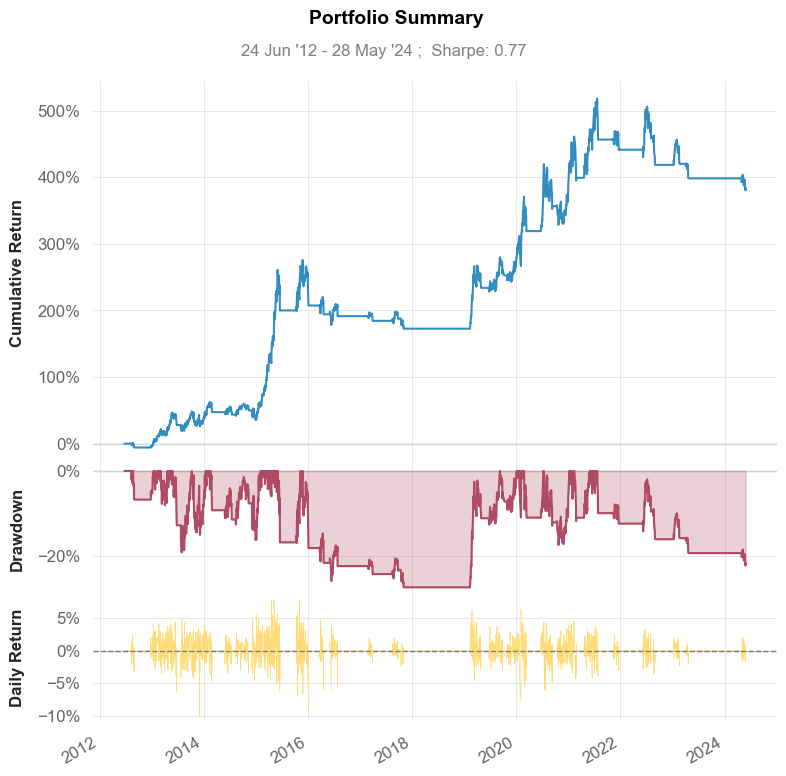

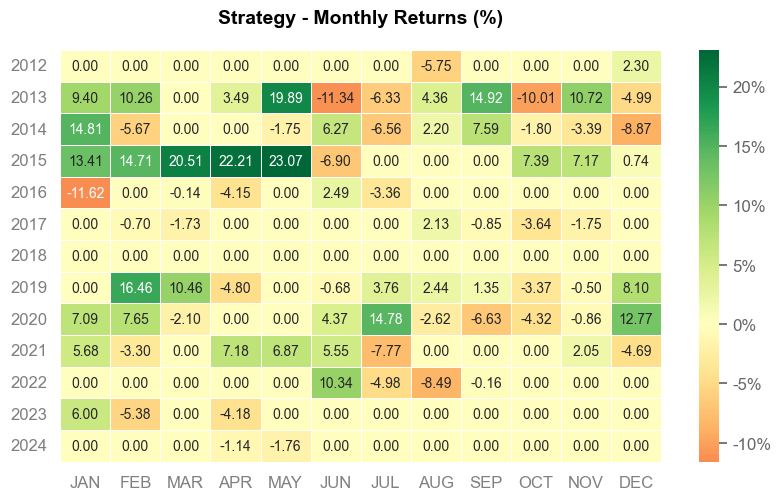

In [15]:
qs.reports.basic(returns)

In [16]:
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo

plotconfig = {
    'id:ind#0': dict(
        subplot=True,
    ),
}
b = Bokeh(style='line', scheme=Tradimo(),plotconfig=plotconfig)


cerebro.plot(b)

[[<backtrader_plotting.bokeh.bokeh.FigurePage at 0x270e85837f0>]]